##  2021:Refinitiv Article series. All rights reserved
## Finding Expired Options and Backtesting a Short Iron Condor Strategy

# Table of content

[Overview](#Overview)<br>
[Install and import packages](#Install-and-import-necessary-packages)<br>
1. [Section 1: Reconstruct expired option RICs](#Section-1:-Reconstruct-expired-option-RICs)<br>
    1.1 [Function for Expiration days](#1.1-Function-for-Expiration-days)<br>
    1.2 [Function for Transaction days](#1.2-Function-for-Transaction-days)<br>
    1.3 [Function to get adjustment factor of stock split](#1.3-Function-to-get-adjustment-factor-of-stock-split)<br>
    1.4 [Function to get potential RICs](#1.4-Function-to-get-potential-RICs)<br>
    1.5 [Function to validate potential RICs](#1.5-Function-to-validate-potential-RICs)<br>
2. [Section 2: Option transactions and strategy outcome](#Section-2:-option-transactions-and-strategy-outcome)<br>
    2.1 [Function to create option positions](#2.1-Function-to-create-option-positions)<br>
    2.2 [Function to offset positions](#2.2-Function-to-offset-positions)<br>
    2.3 [Function to calculate and report the outcome of the strategy](#2.3-Function-to-calculate-and-report-the-outcome-of-the-strategy)<br>
3. [Section 3: Implement and visualize short iron condor strategy](#Section-3:-Implement-and-visualize-short-iron-condor-strategy-outcome)<br>
    3.1 [Implement short iron condor strategy](#3.1-Implement-short-iron-condor-strategy)<br>
    3.2 [Visualize the outcome of the strategy](#3.2-Visualize-the-outcome-of-the-strategy)<br>
    
[Summary](#Summary)

### Overview

This article explores how [short iron condor strategies](https://www.fidelity.com/learning-center/investment-products/options/options-strategy-guide/short-iron-condor-spread) can be backtested. The important part of this article is the reconstruction of expired options, which used to be a challenge  reported many times in the [Developer community](https://developers.refinitiv.com/en/) Q&A forum. The challenge is that one cannot directly access expired options through a single API call. To get historical data on options, one will need to reconstruct options Refinitiv Identification Codes (RIC) following the logic of RIC construction rules and the rules specified by the exchange where the option is traded. Further, in this article, RIC reconstruction and validation functions are presented; they can be used for options on OPRA exchange-traded indices and stocks. Functions reconstruct and validate AM settlement options expiring on the 3rd Friday of each month.

In this article, we test and visualize the profit/loss of the short Iron Condor strategy with 10% and 20% Out of Money (OTM) sizes for NDX; however one can use the functions and codes of this article to backtest other OPRA exchange-traded indices (such as SPX) and equities (such as IBM, TWTR) at the same time specifying OTM sizes other than 10/20%. It should be noted that options with different underlying assets have different liquidity, and one may not get data for specific OTM ranges for some underlying assets. The current backtesting model is not at the production level and is not tested on a wide range of underlying assets. Except for NDX, we tested the functions on SPX, IBM, TWTR and AAPL, which produced the required results to be used for backtesting of options on these assets. Additionally, we considered also the impact of stock split event on the underlying price and strike price, and adjusted the prices accordingly. The impact of other corporate events, such as stock dividends, right offering, M&A is not considerd and tested in the scope of this article.

The article follows the following structure. In Section 1, we build and present a function for expired option RIC reconstruction and validation. Section 2 introduces functions to conduct option transactions to build iron condor legs and report the strategy outcome. Also, we use a function to offset the transactions before expiration based on VIX movements. Finally,  Section 3 implements a short iron condor strategy on NDX and visualizes the backtesting results.

### Install and import packages

To start, we first install and import the necessary packages. We use the Refinitiv Data platform API to retrieve the data. To do that, we need to authorize ourselves with an app key. The code are built using Python 3.9. Other prerequisite packages are installed below:

In [ ]:
!pip install refinitiv.dataplatform

In [ ]:
!pip install plotly

In [ ]:
!pip install pandas_market_calendars

In [1]:
import refinitiv.dataplatform as rdp
import calendar
import numpy as np
import pandas as pd
import datetime as dt
import pandas_market_calendars as mcal
from datetime import timedelta
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter.marker import Line
import warnings
warnings.filterwarnings("ignore")

# read AppKey from a text file and authorize yourself
app_key = open("app_key.txt","r").read()
rdp.open_desktop_session(app_key)

### Section 1: Reconstruct expired option RICs

Below, we illustrate the Refinitiv Identification Code (RIC) structure of an expired option on the NASDAQ 100 index (NDX) as an underlying. Options on other indices and equities follow the same structure. The first three letters indicate the **name of the asset**, which can be a maximum of 5 for other assets according to 'RULES7'. The following letter represents the **Expiration month code**, which is different for put and call options and can be found in 'RULES2'. Additionally, the letter indicating expiration month is lower case for any strikes > 999.999. The following two digits represent the **Expiration day**, which is the 3rd Friday of every month for AM settled monthly options. This is followed by another two digits indicating the **Expiration year**. Subsequently, we have five characters for the **Strike price** with different integral and decimal part combinations depending on the value of the strike price (more can be found in 'RULES7'). "." followed by up to 2 characters is the **Exchange code**, OPRA in the examined case. "^" symbol indicates that the option is expired, which is followed by the **Expiration month code** and the **Expiration year**. Based on the following considerations, the first RIC from the below image is the RIC for NDX call option with a strike price of 12100, which was traded at OPRA Exchange and expired on November 20, 2020. The other RIC is a put option with a strike price of 10425.

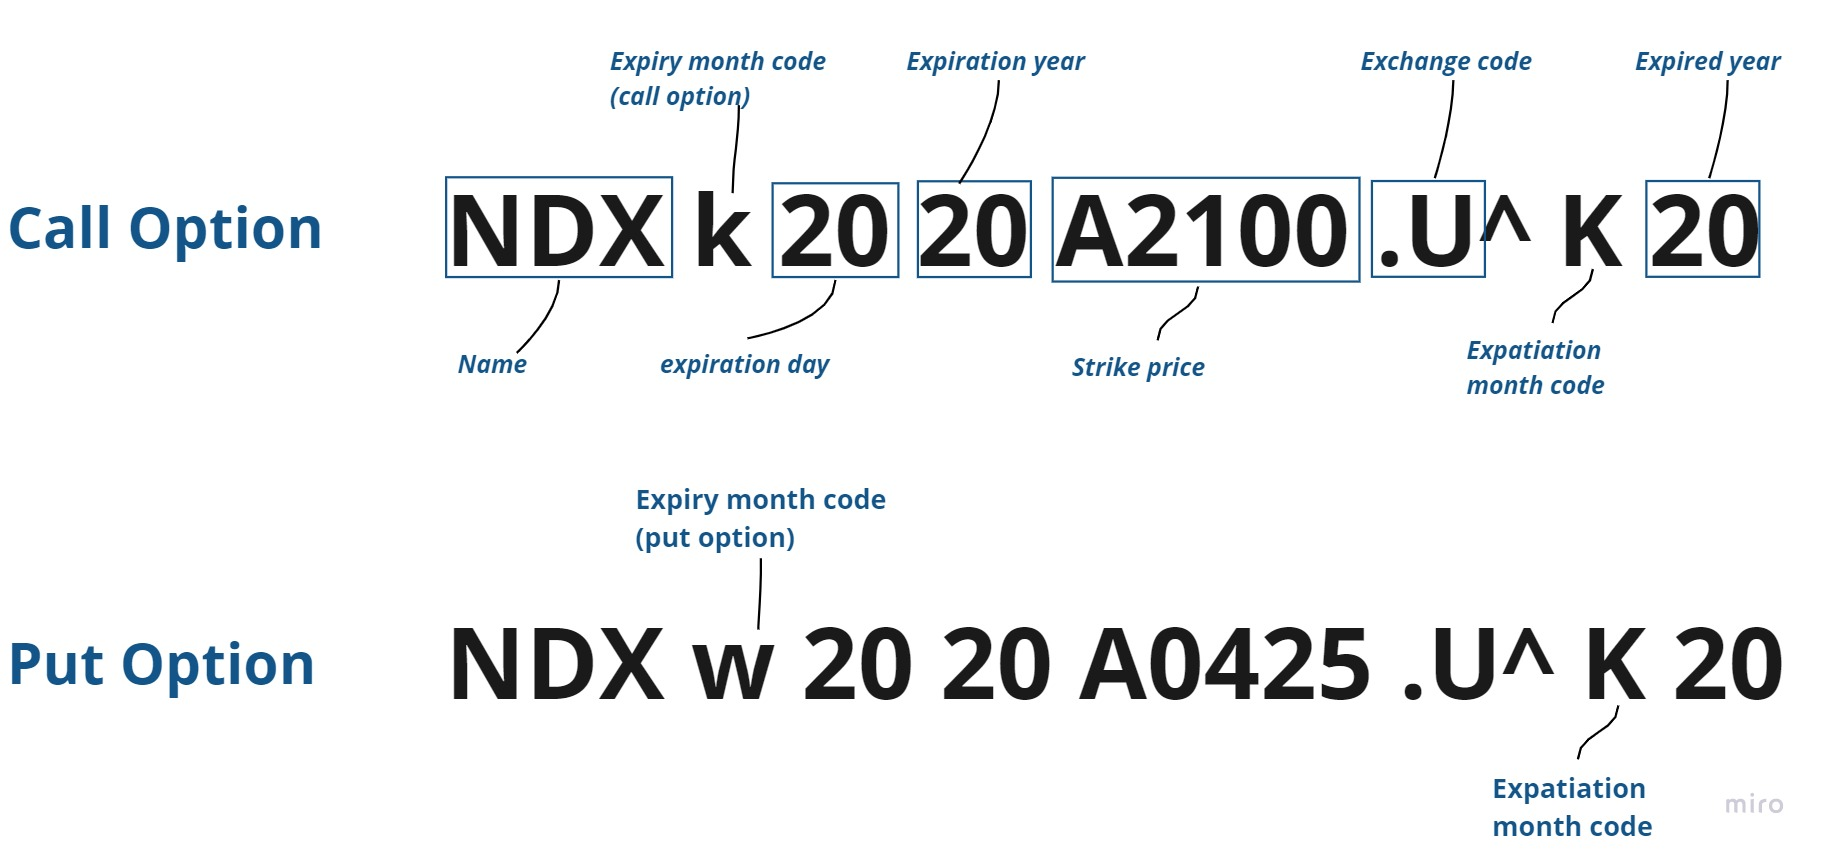

Below can be found the comprehensive list of Rules used to reconstruct expired option RICs on indices and equities.

>**RULES7** | RIC rules to construct options on equities and indices (search in Workspace).

>**RULES2** | RIC Rules for Delivery Month Codes for Futures & Options (search in Workspace).

>**RULES3** and **RULES4** | RIC Rules for Exchange Identifiers (search in Workspace).

>**Guideline to pull expired options in Refinitiv Eikon** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2018/09/000178972.html).

>**Guideline on RIC structure Enhancement for Strike Price 10000 and above** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/datanotification/DN099473.html).

>**Equity Options Product Specifications** | CBOE exchange rules to be accessed [here](https://www.cboe.com/exchange_traded_stock/equity_options_spec/).

>**SPX Options Product Specification** | CBOE exchange rules to be accessed [here](https://www.cboe.com/tradable_products/sp_500/spx_options/specifications/).

>**NDX options Product Specification** | NASDAQ Factsheet to be accessed [here](https://www.nasdaq.com/docs/2021/02/01/NDXFactSheet.pdf).

In order to reconstruct RICs, we need to get all the required components of the RIC structure presented above. Most of the components are inputted directly to the function **get_potential_rics** introduced further in this article, whereas we have constructed separate functions to get Expiration days and Transaction days (we need this for the strike price component) as we will need to call those functions several times throughout the process. 

Additionally, we check for stock split corporate events for equities. Those are the one of the most common corporate event types, and will greatly impact on the underlying price and therefore on the strike price component of the RIC. In case there is a stock split event impacting on the prices we adjust the historical prices by an adjustment factor to make sure we arrive at a valid strike and reconstruct a valid RIC.

#### 1.1 Function for Expiration days

First, we define a function to get expiration dates for each month. Since AM settled monthly options expire on the 3rd Friday of each month, we define a function that gets that after having a year as an input. It should be noted that the function also considers exchange holidays, and if a day is a holiday, the previous day is considered as suggested by the exchange rules. 

***For the current and for all the following functions, code explanations are made in code cell by using code comments***

In [2]:
def get_exp_dates(year):
    '''
    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.
    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2
    
    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested
        
    Output:
        dates(dict): dictionary of expiration days for each month of a specified year
    '''
    
    # get CBOE market holidays
    CBOE = mcal.get_calendar('CBOE_Index_Options')
    holidays = CBOE.holidays().holidays
    
    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)
    
    # get the 3rd Friday of each month 
    exp_dates = {}
    for i in range(1, 13):        
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previous date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            exp_dates[year].append(date.day)
        else:
            exp_dates[year] = [date.day]        
    return exp_dates

Below we run the function to showcase the output for 2020

In [3]:
dates = get_exp_dates(2020)
dates

{2020: [17, 21, 20, 17, 15, 19, 17, 21, 18, 16, 20, 18]}

#### 1.2 Function for Transaction days

Next, we define a function returning a transaction day for each of 12 months which is used when ***a. Requesting underlying asset prices, based on which we calculate strike prices while also considering the specified Out of Money (OTM) size***, and ***b. Conducting monthly option transaction***.

We provide two possible days for conducting option transactions which are controlled by the function parameter: 1. First business day of each month, 2. Third Friday (which matches with general expiration cycles) of each month. We always open options contract positions to be expiring on the following month of the purchase. For example, for January 2021, we open an option contract expiring on February 2021 either on the first business day, which is January 4, or on the third Friday of the month, which is January 15.

In [4]:
def get_trans_days(year, trans_day = 'first'):
    '''
    This function gets transaction days for each month of a specified year.
    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2
    
    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
                                            
    Output:
        trans_days (list): list of days for 12 month
    '''
    # get the first business day of each month
    if trans_day == 'first':
        CBOE = mcal.get_calendar('CBOE_Index_Options')
        holidays = CBOE.holidays().holidays
        
        # set start and end day ranges
        start_date = str(year) + '-01' +'-01'
        end_date = str(year) + '-12' + '-31'
        trans_days = []
        
        for date in pd.date_range(start_date, end_date, freq='BMS'):
            # get the first day after the weekend after checking for holiday
            while date.isoweekday() > 5 or date in holidays:
                date += dt.timedelta(1)
            # add found day to the list
            trans_days.append(date.date().day)
            
    # get the 3rd Friday for each month by calling function "get_exp_dates"
    elif trans_day == 'third':
        trans_days = get_exp_dates(year)[year]
    else:
        print('Please input "first" or "third" for transaction day')
        return
    return trans_days

Below we run the function to showcase the output for 2020 with a parameter value of 'first'.

In [5]:
trans_days = get_trans_days(2020, 'first')
trans_days

[2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1]

#### 1.3 Function to get adjustment factor of stock split

Here, we check for stock split corporate events for equities and retrieve the adjustment factor. Further, the adjustment factor is used to adjust underlying prices and strike price of option contracts. The function takes asset RIC, expiration day as input and returns the adjustment factor. If no stock split event happened after the expiration date of an option, the function returns adjustment factor of 1, which, in fact, doesn't change the price values. It should be noted that if more than one stock split happened after the expiration date, we need to take into consideration the two adjustments combined.

In [6]:
def adjustment_factor(asset, exp_date):
    '''
    This function gets adjustment factor of stock split for a given asset. If no split event is happened during the requested period
    function returns 1, which assumes no adjustment in prices.
    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2
    
    Parameters
    -----------------------------------------------
    Input:
        asset (str): RIC code of the asset
        exp_date (str with date (YYYY-MM-DD) format): Expiration date for an option on the given asset                                          
    Output:
        adj_factor (float): Adjustment factor after split
    ''' 
    # request information on stock split corporate events. The request is done on current day during the previous 50 year period
    corp_event, err = rdp.legacy.get_data(asset, ['TR.CAEffectiveDate','TR.CAAdjustmentFactor','TR.CAAdjustmentType'],
                              {'CAEventType':'SSP','SDate':datetime.today().strftime('%Y-%m-%d'),'EDate':'-50Y'})
    
    # if no stock split corporate event adjustment factor is 1
    if pd.isna(corp_event.iloc[0, 1]):
        adj_factor = 1
    else:
        # if there are split events, we first check if the expiration date of option is after or before the adjustment date
        for i in reversed(range(len(corp_event))):
            # if expiration date is bigger than adjustment date, then no need for adjustment
            if pd.to_datetime(exp_date).strftime('%Y-%m-%d') > corp_event['Capital Change Effective Date'][i]:
                adj_factor = 1
            # if expiration date is smaller than adjustment date then we need adjustment
            elif pd.to_datetime(exp_date).strftime('%Y-%m-%d') < corp_event['Capital Change Effective Date'][i]:
                adj_factor = corp_event['Adjustment Factor'][i] * adj_factor # we should consider all adjustment factors which are after the expiration day
    return adj_factor

#### 1.4 Function to get potential RICs

As mentioned earlier, most of the RIC components are constructed via a separate function introduced below. This function calls the functions mentioned above and uses the input to construct other components of RIC. The function takes the year, transaction day, asset name, OTM size, tolerated difference in OTM size, and option type as an input and returns a dictionary of potential RICs per month. For each month, it produces several RICs, which depend on the parameter of tolerated difference in OTM size. We use tolerated difference in OTM because it is mostly impossible to arrive at a valid strike price with any specified OTM. 

The general workflow on how the function works is illustrated in the image below: 

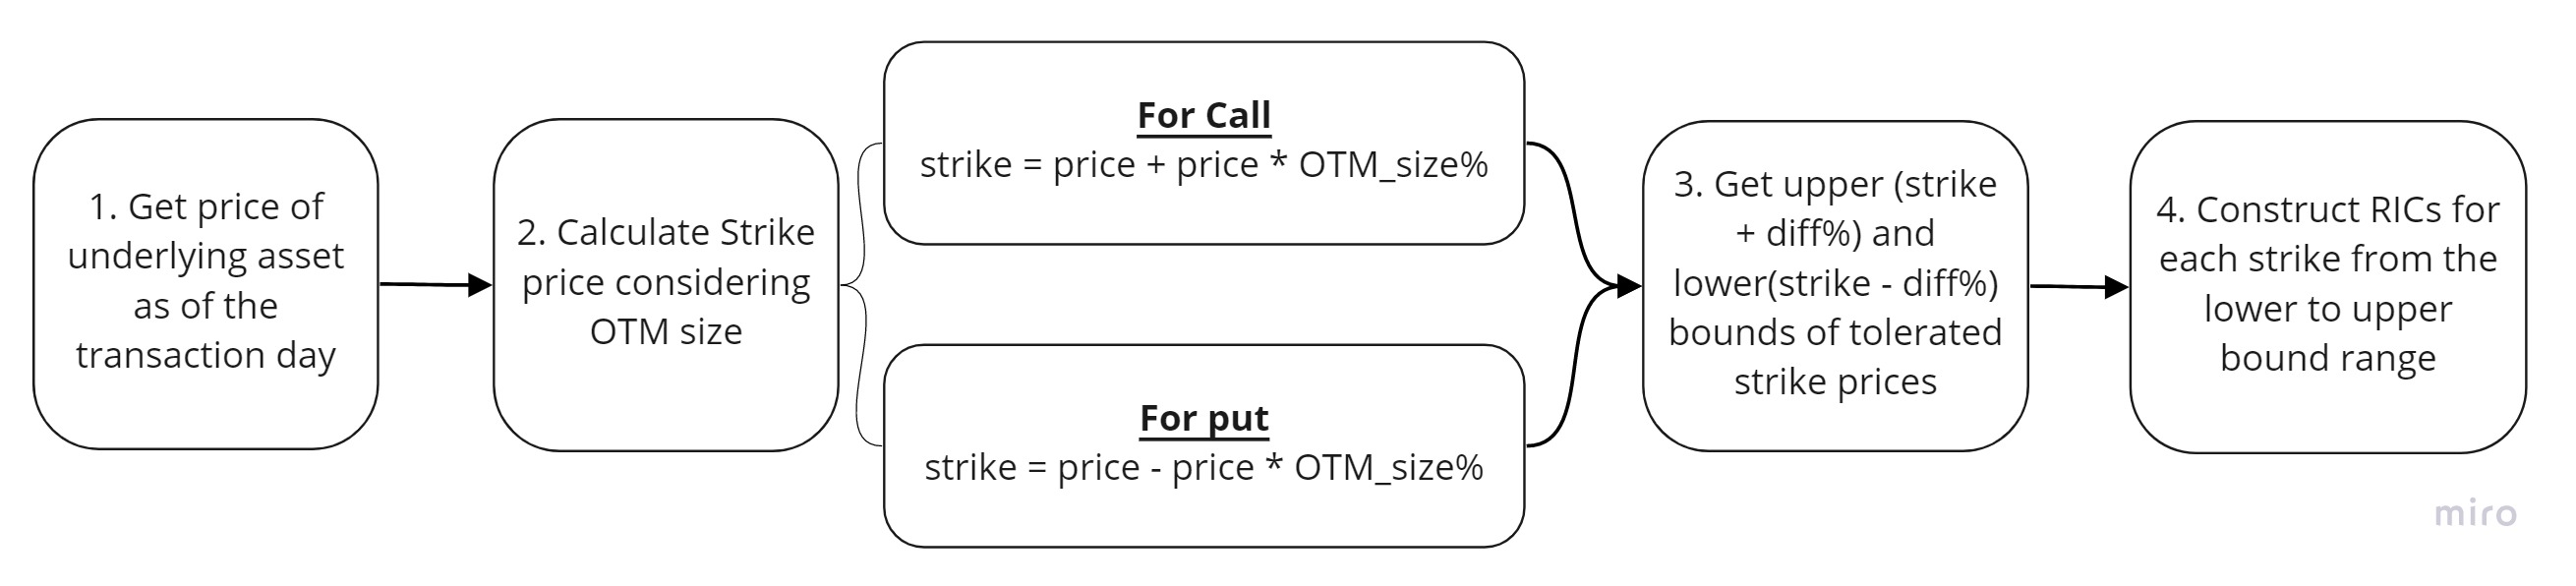

The function works for both indices and equities. The exact RIC codes (e.g., ".NDX" or 'MSFT.O') for each asset needs to be given to the function. Further, the function trims the necessary part of the asset RIC for option RIC construction. The rest of the details on constructing each component of an option RIC is explained inside the code as comments.

After the code is fully executed, we report the logs in a text file.

In [7]:
def get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type):
    '''
    This function returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.
    Dependencies
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1
    
    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
        asset (str): RIC code of the asset
        OTM_size (int): percentage number indicating how far away is the strike price from the price of the underlying asset
        diff (int): Tolarated difference in OTM to construct upper and lower bounds of strike prices
        opt_type (str): takes either "call" or "put"
        
    Output:
        potential_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bounds of strikes
        strikes (list): list of the strike prices calculated based on OTM size for each month
    '''
        
    # open file to report log of the function output
    report = open("Log report.txt", "a")
    
    # call functions to get expiration and transaction days
    trans_days = get_trans_days(year, trans_day)
    trans_days_prev = get_trans_days(year - 1, trans_day)
    dates = get_exp_dates(year) 
    
    # trim underlying asset's RIC to get the required part for option RIC
    if asset[0] == '.': # we remove "." symbol for index options
        asset_name = asset[1:]
    else:
        asset_name = asset.split('.')[0] # we need only the first part of the RICs for equities
        
    # define expiration month codes to be used after "^" sign
    exp = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
    potential_RICs = {}
    strikes = []
    
    # construct potential RICs for each month of a specified year
    for j in range(1,13):
        # get day of expiration for a month
        day = dates[year][j - 1]
        # get date of price request, which is in the previous month of expiration 
        if j != 1: 
            date = str(year) + '-' + str(j - 1) + '-' + str(trans_days[j - 2])
        if j == 1: # for January, we need to subtract a year along with the month
            date = str(year - 1) + '-' + str(j + 11) + '-' + str(trans_days_prev[j + 10])    
        # get price of underlying asset as of the transaction date
        
        # get expiration date to be used to check stock split corporate events
        exp_date = str(year) + '-' + str(j) + '-' + str(trans_days[j - 1])
        # run adjustment_factor function to get the factor
        adj_factor = adjustment_factor(asset, exp_date)

        price, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': date})
        price = price.iloc[0,1] / adj_factor # adjust prices by the adjustment factor. if no sptick split events adj_factor = 1
                
        # calculate the strike price for call options
        if opt_type.lower() == 'call':
            strike = price + price * OTM_size / 100
            # define expiration month codes for call options while also considering the strike price
            if strike > 999.999:
                exp_codes_call = ['a', 'b', 'c', 'd','e','f','g', 'h', 'i', 'j', 'k', 'l']
            else:
                exp_codes_call = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
            # get expiration month code for a month
            exp_month = exp_codes_call[j-1]
            
        # calculate the strike price and get expiration month code for a month for put options
        elif opt_type.lower() == 'put':
            strike = price - price * OTM_size/100
            if strike > 999.999:
                exp_codes_put = ['m', 'n', 'o', 'p','q','r','s', 't', 'u', 'v', 'w', 'x'] 
            else:
                exp_codes_put = ['M', 'N', 'O', 'P','Q','R','S', 'T', 'U', 'V', 'W', 'X']
            exp_month = exp_codes_put[j-1]
            
        strikes.append(int(round(strike,0))) # append the calculated strike price to the list of strikes
        
        # calculate lower and upper bounds for strikes considering the value of the strike
        if strike > 999.999:
            step = 5 # we loop over strikes with a step 5 for larger strikes
            strike_ub = int(round((strike + strike * diff / 100),-1))
            strike_lb = int(round((strike - strike * diff / 100),-1))
        else:
            step = 1 # we loop over strikes with a step 1 for smaller strikes
            strike_ub = int(strike + strike * diff / 100)
            strike_lb = int(strike - strike * diff / 100)
        
        # construct RICs for each strike from the lower to upper bound ranges of strikes
        for n in range(strike_lb, strike_ub + step, step):
            k = None # for strikes < 1000 along with 1 step increment change in strikes we do 0.5 point increment change which 
                     #allows us to consider strikes with decimal points. This is important to get closer OTMs for smaller valued assets.
            # here we construct option RICs by adding together all the RIC components
            # Please note some of the components are different depending on the strike value
            plc_holdr1 = asset_name + exp_month + str(day) + str(year)[-2:]
            plc_holdr2 = exp[j - 1] + str(year)[-2:]
            if n < 10:
                z = plc_holdr1 + '00' + str(n) + '00.U^' + plc_holdr2# for integer steps
                k = plc_holdr1 + '00' + str(n) + '50.U^' + plc_holdr2# for decimal steps
            elif n >= 10 and n < 100:
                z = plc_holdr1 + '0' + str(n) + '00.U^' + plc_holdr2
                k = plc_holdr1 + '0' + str(n) + '50.U^' + plc_holdr2
            if n >= 100 and n < 1000:
                z = plc_holdr1 + str(n) + '00.U^' + plc_holdr2  
                k = plc_holdr1 + str(n) + '50.U^' + plc_holdr2
            elif n >= 1000 and n < 10000:
                z = plc_holdr1 + str(n) + '0.U^' + plc_holdr2
            elif n >= 10000 and n < 20000:
                z = plc_holdr1 + 'A' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 20000 and n < 30000:
                z = plc_holdr1 + 'B' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 30000 and n < 40000:
                z = plc_holdr1 + 'C' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 40000 and n < 50000:
                z = plc_holdr1 + 'D' + str(n)[-4:] + '.U^' + plc_holdr2
            
            # append RICs with integer strikes to the dictionary
            if j in potential_RICs:
                potential_RICs[j].append(z)
                # append RICs with decimal point strikes to the dictionary
                if k is not None:
                    potential_RICs[j].append(k)
            else:
                potential_RICs[j] = [z]
                if k is not None:
                    potential_RICs[j].append(k)  
                    
    # report funtion results and close the log file
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
    report.close()
    return potential_RICs, strikes

Below we run the function to showcase the output for call options for 2020 with 10% OTM and 0.5% tolerance.

In [127]:
call_RICs, call_strikes = get_potential_rics(2020, 'first','.NDX', 10, 0.5, 'call')
print(call_RICs)

{1: ['NDXa172090900.U^A20', 'NDXa172090950.U^A20', 'NDXa172091000.U^A20', 'NDXa172091050.U^A20', 'NDXa172091100.U^A20', 'NDXa172091150.U^A20', 'NDXa172091200.U^A20', 'NDXa172091250.U^A20', 'NDXa172091300.U^A20', 'NDXa172091350.U^A20', 'NDXa172091400.U^A20', 'NDXa172091450.U^A20', 'NDXa172091500.U^A20', 'NDXa172091550.U^A20', 'NDXa172091600.U^A20', 'NDXa172091650.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091800.U^A20', 'NDXa172091850.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097100.U^B20', 'NDXb212097150.U^B20', 'NDXb212097200.U^B20', 'NDXb212097250.U^B20', 'NDXb212097300.U^B20', 'NDXb212097350.U^B20', 'NDXb212097400.U^B20', 'NDXb212097450.U^B20', 'NDXb212097500.U^B20', 'NDXb212097550.U^B20', 'NDXb212097600.U^B20', 'NDXb212097650.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097800.U^B20', 'NDXb212097850.U^B20', 'NDXb212097900.U^B20', 'NDXb212097950.U^B20', 'NDXb212098000.U^B20', 'NDXb212098050.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc202099900.U^C2

The function get_potential_rics lists the RICs for each month with strike prices ranging from lower to upper strike bounds. In order to make sure we are trading the option with a strike price closest to the specified OTM price, we need to sort the RICs of each month in order of closeness of options contract strike price with the OTM price. The function below takes potential RICs and strike prices (calculated based on OTM) as an input and returns the sorted dictionary of RICs.

In [128]:
def sort_option(pot_RICs, strikes):
    '''
    This function sorts the potential RICs in order of closeness of option contract strike price with the underlying asset price with given OTM.
    --------------------------------------
    Input:
        pot_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bounds of strikes
        strikes (list): list of strike prices calculated based on the OTM size for each month 
        
    Output:
        pot_RICs (dict): dictionary containing potential RICs for each month sorted in order of closeness of option contract strike price with the underlying asset price with given OTM
    '''
    i = -1
    strike_letters = ['A', 'B', 'C', 'D']
    # loop over each month
    for month in pot_RICs:
        i += 1
        # loop over each RIC per month
        for RIC in pot_RICs[month]:
            # calculate the absolute difference of option strike price and the strike price calculated based on the specified OTM size
            sort = [abs(int(RIC[-11:-7]) - int((str(strikes[i])[-4:] + '0')[:4])) if RIC[-11] not in strike_letters else 
                    abs(int(RIC[-10:-6]) - int(str(strikes[i])[-4:])) for RIC in pot_RICs[month]]
            # sort original dictionary with the sort order
            pot_RICs[month] = [month_sorted for _, month_sorted in sorted(zip(sort, pot_RICs[month]))]
    return pot_RICs

Below we run the function to showcase the sorted output.

In [153]:
call_sorted = sort_option(call_RICs,  call_strikes)
print(call_sorted)

{1: ['NDXa172091400.U^A20', 'NDXa172091350.U^A20', 'NDXa172091450.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091550.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091150.U^A20', 'NDXa172091650.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091050.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090950.U^A20', 'NDXa172091850.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097550.U^B20', 'NDXb212097650.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097450.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097350.U^B20', 'NDXb212097850.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097950.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097150.U^B20', 'NDXb212098050.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C2

#### 1.5 Function to validate potential RICs

As the name of the get_potential_rics function indicates, it produces a list of potential RICs, part of which (sometimes all, if you request for higher OTMs for illiquid option contract) is not an actual RIC. In order to validate those, we need to make API calls. Here we use the **get_historical_price_summaries** function from the RDP API, which results in *"None"* if the RIC is invalid; otherwise, it returns the values from the specified fields. One may use **get_date** function from Eikon API; however, it returns an error if the RIC is invalid, and one may need to write try/except loop and hide the errors/warnings. 

It should be noted that the function mentioned below should be **used only** if one wants to **validate all RICs** from the list of potential RICs. As a rule, in options strategy backtesting, when one finds a valid RIC for a month, one does not have to test others from that month as the option contract with the closest OTM size is already found for trading. In our example, to test the short iron condor strategy, we do not call this function; instead, we check the validity of a RIC right inside the transaction function (see function **trans_option**) to avoid extensive API requests and hitting the daily limit of 10000 requests.

In [9]:
def get_valid_rics(year, trans_day, pot_RICs_sorted):
    '''
    This function checks the validity of a RIC by making API calls and returns dictionary of valid RICs per month for a specified year. 
    Dependencies
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1
    
    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
        pot_RICs_sorted (dict): dictionary containing potential RICs which are already sorted
        
    Output:
        valid_rics (dict): dictionary containing validated RICs for each month
    '''
    report = open("Log report.txt", "a")
    
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year - 1, trans_day)
    valid_rics = {}
    
    # get start and end date of the api requests
    for month in pot_RICs_sorted:
        edate = str(year) + '-' + str(month) + '-' + str(dates[year][month - 1])
        if month > 1:
            sdate = str(year) + '-' + str(month - 1) + '-' + str(trans_days[month - 2])
        if month == 1:
            sdate = str(year-1) + '-' + str(month + 11) + '-' + str(trans_days_prev[month + 10])
        
        # make an API call for each RIC for each month
        for RIC in pot_RICs_sorted[month]:
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])  
            # add valid RICs to the dictionary
            if vals is not None:
                vals.reset_index(inplace = True)
                if month in valid_rics:
                    valid_rics[month].append(RIC)
                else:
                    valid_rics[month] = [RIC]
                    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Valid RICs with specified criteria for {len(valid_rics)} month during {year} are found\n')
    report.close()
    return valid_rics

Below we run the function to showcase the valid RICs.

In [154]:
valid_rics_call = get_valid_rics(2020,'first', call_sorted)
print(valid_rics_call)

{1: ['NDXa172091400.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C20', 'NDXc2020A0030.U^C20', 'NDXc2020A0050.U^C20', 'NDXc2020A0025.U^C20', 'NDXc2020A0020.U^C20', 'NDXc2020A0060.U^C20', 'NDXc2020A0010.U^C20', 'NDXc2020A0070.U^C20', 'NDXc2020A0075.U^C20', 'NDXc2020A0000.U^C20', 'NDXc2020A0080.U^C20', 'NDXc2020A0090.U^C20', 'NDXc202099900.U^C20'], 4: ['NDXd172097750.U^D20', 'NDXd172097500.U^D20', 'NDXd172098000.U^D20', 'NDXd172097250

## Section 2: Option transactions and strategy outcome

After we have the list of potential RICs for each month, we trade them by taking long or short positions for a contract every month of a given year. The **trans_option** function takes the year, transaction day ("first" or "third"), asset name, potential sorted RICs, option type and position ("short" or "long") and returns a dataframe consisting of transaction details.

Here should be additionally stated that the function works by the potential RICs, and one does not have to run the function **get_valid_rics**. This function takes the first RIC from the month (already sorted having the ones we want at the beginning) and checks the validity by requesting  Trade, BID, and ASK prices through RDP API function **get_historical_price_summaries**. If valid, the prices are considered for the trade; if not, the next RIC is tried. This continues until a valid RIC with a valid option contract price is found for a month. If no valid RIC is found for a month, no option contract is traded for that month, which is reported in the Log file accordingly. As it comes to the valid option contract price, it is considered to be one of the following (in order as provided below):

**a.** Trade price
   
**b.** BID/ASK mid price
   
**c.** ASK price minus average bid/ask spread for the period
   
**d.** BID price plus average bid/ask spread for the period
   
**e.** ASK price
   
**f.** BID price

In order to get more values for a more robust estimate of the option contract price, we request price data from 2 months before the transaction date. The transaction date is either the first business day or the 3rd Friday of every month, which needs to be specified as a function parameter. Options expire in the expiration cycle of the following month of the purchase.

The rest of the details on building a dataframe of transaction details is explained inside the code as comments.

After the code is fully executed, we report the logs in a text file.

#### 2.1 Function to create option positions

In [25]:
def trans_option(year, trans_day, asset, RICs, opt_type, position):
    '''
    This function registers the option contract buy/sell transactions for each month in a given year along with other transaction details,
    such as strike price, underlying price, actual OTM size etc.  
    Dependencies
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1
    Python library 'Pandas' version 1.3.3
    
    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
        asset (str): RIC code of the asset
        RICs (dict): dictionary containing potential RICs which are already sorted
        opt_type (str): takes either "call" or "put"
        position (str): takes either "short" or "long"
        
    Output:
        trans_details (DataFrame): Pandas DataFrame containing transaction details
    '''
    report = open("Log report.txt", "a")
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year-1, trans_day)
    
    # create empty disctionary with the transaction details as keys
    trans_details = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for month in RICs:
        # get start and end date of the api requests
        edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
        if month > 2:
            sdate = str(year) + '-' + str(month - 1) + '-' + str(trans_days[month - 2])
            sdate_req = str(year) + '-' + str(month - 2) + '-' + str(trans_days[month - 3]) # we request 2 month before the trans days for option contract prices 
        if month == 1:
            sdate = str(year - 1) + '-' + str(month + 11) + '-' + str(trans_days_prev[month + 10])
            sdate_req = str(year - 1) + '-' + str(month + 10) + '-' + str(trans_days_prev[month-4])
        if month == 2:
            sdate = str(year) + '-' + str(month - 1) + '-' + str(trans_days[month-2])
            sdate_req = str(year - 1) + '-' + str(month + 10) + '-' + str(trans_days_prev[month-4])
        # get adjustment factor
        adj_factor = adjustment_factor(asset, edate)
        for RIC in RICs[month]:
            # request option contract prices
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate_req, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])     
            
            # check validity of a RIC and if valid register the transaction details
            if vals is not None:
                vals.reset_index(inplace = True)
                # get the best price for option contract trade with the order as sepcified in the cell above
                if vals.loc[vals['index'] == sdate].shape[0] == 1:
                    if len(vals['TRDPRC_1'].loc[vals['index'] == sdate]) == 1 and vals['TRDPRC_1'].loc[vals['index'] == sdate].notna().any():
                        price = vals['TRDPRC_1'].loc[vals['index'] == sdate].values[0]
                    elif (vals['ASK']).sum() == 0 and (vals['BID']).sum() != 0:
                        price = vals['BID'].loc[vals['index'] == sdate].values[0]  
                    elif (vals['ASK']).sum() != 0 and (vals['BID']).sum() == 0:
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0]
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        price = (vals['ASK'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0]) / 2
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == False:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['ASK']).mean()
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0] - vals['ASK'].loc[vals['index'] == sdate].values[0] * av_spread
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == False and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['BID']).mean()
                        price = vals['BID'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0] * av_spread  
                    
                    # if valid price is found register some of the transaction details
                    trans_details['Option Price'].append(round(float(price),2))
                    trans_details['Trans_Date'].append(vals['index'].loc[vals['index'] == sdate].values[0])
                    trans_details['Option type'].append(opt_type.lower())
                    trans_details['Exp_date'].append(datetime.strptime(edate, '%Y-%m-%d'))
                    trans_details['RIC'].append(RIC)              
                    trans_details['Position'].append(position.lower())
                    
                    # to construct strike price, calculate OTM size and add those (along with the price) to the transaction details 
                    # we need to request the underlying price as of the transaction date
                    prices = []
                    
                    # # get adjustment factor
                    # adj_factor = adjustment_factor(asset, edate)
                    val, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': sdate})
                    price = val.iloc[0,1] / adj_factor # adjust prices. adj_factor = 1, if no stock split event for the requested date
                    trans_details['Price_Trans_Date'].append(price)
                    
                    # get the integer and decimal parts of the strike price depending on the underlying asset price value
                    # for prices < 1000 we get both integer and decimal parts
                    # strikes are constructed according to RULES7
                    if price < 10:
                        int_part = int(RIC[-11:-8])
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 10 and price < 100:
                        int_part = RIC[-11:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 100 and price < 1000:
                        int_part = RIC[-11:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 1000 and price < 10000:
                        if RIC[-11] == 'A': # sometimes when underlying price is closer to 10000, the strike with OTM size falls in the range of >10000
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else:
                            strike = float(RIC[-11:-7])
                    elif price >= 10000 and price < 20000:
                        if RIC[-11] == 'A':
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else: # sometimes when underlying price is closer to 10000, the strike with OTM size falls in the range of <10000
                            strike = float(RIC[-11:-7]) 
                    elif price >= 20000 and price < 30000:
                        strike = float(RIC[-11:-6].replace('B', "2"))
                    elif price >= 30000 and price < 40000:
                        strike = float(RIC[-11:-6].replace('C', "3"))
                    elif price >= 40000 and price < 50000:
                        strike = float(RIC[-11:-6].replace('D', "4"))
                    trans_details['Strike'].append(strike)
                    
                    # calculate and register actual OTM size
                    if opt_type.lower() == 'call':
                        OTM = round((strike - price) / price * 100, 2)
                    elif opt_type.lower() == 'put':
                        OTM = round((price - strike) / price * 100, 2)  
                    trans_details['OTM size'].append(OTM)
                    break # stop the loop if an option contract is traded and all transaction details are added
                    
        # check if an option contract is purchased for a month and report if not
        if datetime.strptime(edate, '%Y-%m-%d') not in trans_details['Exp_date']:
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: No {opt_type} option is purchased for month {month}\n')
    
    # report total number of transactions during a year
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(pd.DataFrame(trans_details))} {position} {opt_type} transactions for {year} are registered\n')
    report.close()
    return pd.DataFrame(trans_details)

Below we run the function to showcase the resulting dataframe of the transaction output. Explanations follow the dataframe table.

In [130]:
call_trans = trans_option(2020,'first', '.NDX', call_sorted, 'call', 'short')
call_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12
1,NDXb212098000.U^B20,2020-01-02,2020-02-21,call,short,9800.0,8872.219,1.83,10.46
2,NDXc2020A0000.U^C20,2020-02-03,2020-03-20,call,short,10000.0,9126.232,2.77,9.57
3,NDXd172097750.U^D20,2020-03-02,2020-04-17,call,short,9775.0,8877.978,15.45,10.10
4,NDXe152082500.U^E20,2020-04-01,2020-05-15,call,short,8250.0,7486.287,135.10,10.20
5,NDXf192096000.U^F20,2020-05-01,2020-06-19,call,short,9600.0,8718.179,66.20,10.11
6,NDXg1720A0550.U^G20,2020-06-01,2020-07-17,call,short,10550.0,9598.887,22.85,9.91
7,NDXh2120A1300.U^H20,2020-07-01,2020-08-21,call,short,11300.0,10279.248,40.10,9.93
8,NDXi1820A2150.U^I20,2020-08-03,2020-09-18,call,short,12150.0,11055.076,38.15,9.90
9,NDXj1620A3500.U^J20,2020-09-01,2020-10-16,call,short,13500.0,12292.863,111.50,9.82


As we can see above, the resulting dataframe consists of the following transaction details:

* **RIC** - Option RIC with a strike price closest to the strike calculated based on OTM size (e.g. for call option: strike = price + price * OTM / 100)
* **Trans_Date** - Transaction date, which is either the first business day or the expiration day of a month based on a parameter trans_day
* **Exp_Date** - Expiration day of an option contract, which is the 3rd Friday of each month for OPRA exchange-traded monthly options with AM settlement
* **Option Type** - Call or Put as specified in the respective parameter of the function
* **Position** - Long or Short as specified in the respective parameter of the function
* **Strike** - Strike price of the traded option contract. This is retrieved based on the underlying asset price value and following RULES7
* **Price_trans_Date** - Price of the underlying asset at the transaction date
* **Option Price** - Price of the option contract retrieved/calculated based on the considerations from the cell above
* **OTM size** - The actual size of OTM, calculated based on the underlying asset price and the Strike of the traded option contract

As option strategies are mostly done by pairs we created a separate **pair_trans** function which conducts paired transactions by calling **get_potential_rics**, **sort_option**, and **trans_option** functions for call and put options with the specified parameter values. This function takes the year, trans_day, asset name, OTM sizes, and positions for call and put options and returns transaction details for both call and put option trades.

In [131]:
def pair_trans(year, trans_day, asset, call_OTM, put_OTM, diff, call_pos, put_pos):
    '''
    This function implements option pair transaction by calling some of the abovementioned functions for a call/put pair.
    Dependencies
    ----------------------------------------------
    Python library 'Pandas' version 1.3.3
    
    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
        asset (str): RIC code of the asset
        RICs (dict): dictionary containing potential RICs which are already sorted
        call_OTM (int): OTM size for Call options
        put_OTM (int): OTM size for Put options
        diff (int): tolarated difference in actual OTM size
        call_pos (str): trade position for call options. Takes either "short" or "long"
        put_pos (str): trade position for put options. Takes either "short" or "long"

    Output:
        call_trans (DataFrame): Pandas DataFrame containing transaction details for call options
        put_trans (DataFrame): Pandas DataFrame containing transaction details for put options
    '''  
    # request functions for call options
    call_RICs, call_strikes = get_potential_rics(year, trans_day, asset, call_OTM, diff, 'call')
    call_sorted = sort_option(call_RICs, call_strikes)
    call_trans = trans_option(year, trans_day, asset, call_sorted, 'call', call_pos.lower())

    # request functions for put options
    put_RICs, put_strikes = get_potential_rics(year, trans_day, asset, put_OTM, diff, 'put')
    put_sorted = sort_option(put_RICs, put_strikes)
    put_trans = trans_option(year, trans_day, asset, put_sorted, 'put', put_pos.lower())
    
    # join put and call transactions
    trans = pd.concat([call_trans, put_trans]).reset_index()
    trans.drop(columns = ['index'], inplace = True)
    trans = trans.sort_values(by = ['Exp_date'])

    return trans

Below we run the function to showcase the resulting dataframe of the transaction outputs.

In [132]:
trans = pair_trans(2020, 'first', '.NDX', 10, 20, 2, 'short', 'long')
trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12
12,NDXm172066500.U^A20,2019-12-02,2020-01-17,put,long,6650.0,8309.260,6.45,19.97
1,NDXb212098000.U^B20,2020-01-02,2020-02-21,call,short,9800.0,8872.219,1.83,10.46
13,NDXn212071000.U^B20,2020-01-02,2020-02-21,put,long,7100.0,8872.219,8.10,19.97
2,NDXc2020A0000.U^C20,2020-02-03,2020-03-20,call,short,10000.0,9126.232,2.77,9.57
14,NDXo202073000.U^C20,2020-02-03,2020-03-20,put,long,7300.0,9126.232,12.70,20.01
3,NDXd172097750.U^D20,2020-03-02,2020-04-17,call,short,9775.0,8877.978,15.45,10.10
15,NDXp172071000.U^D20,2020-03-02,2020-04-17,put,long,7100.0,8877.978,62.50,20.03
4,NDXe152082500.U^E20,2020-04-01,2020-05-15,call,short,8250.0,7486.287,135.10,10.20
16,NDXq152060000.U^E20,2020-04-01,2020-05-15,put,long,6000.0,7486.287,102.50,19.85


#### 2.2 Function to offset positions

One will not open positions in option trading strategies and wait until expiration to calculate the strategy outcome. Most of the time, traders use offset models, which create triggers for closing the open positions and calculate the outcome as of the position close day. Traders use sophisticated models for determining offset triggers; however, this article aims not to suggest the best model for that but rather showcase how Refinitiv APIs can be used for option strategy backtesting, which would support both opening and closing of the positions. Thus, in this article, we base our offset strategy on [CBOE Volatility Index (VIX)](https://www.investopedia.com/terms/v/vix.asp). 

Particularly, we first create a threshold equal to 2 standard deviations of the previous 30 days VIX change. Then we calculate the 3-day moving average (MA) of VIX and track MA change after the transaction date. If the MA exceeds the threshold at any point after the position is open, we create an offset transaction to short RICs with long positions and long ones with short positions. Usage of MA, instead of actual VIX change, makes price movements smoother, allowing to avoid False Alarms, and threshold based on previous period's standard deviations allows to adapt to the changing market conditions.

The **exit_trans** function takes the call and put option transactions as an input, and returns a dataframe containing the offset transactions. To conduct offset transactions, the function first requests VIX data from RDP API function **get_historical_price_summaries** for each transaction date of inputted option transactions. The request period is from 30 days before the transaction to the expiration date of the respective option contract. Then based on the VIX trade price, the function calculates VIX change and the MA (including the change). Finally, the threshold for that month is calculated. Then, the function loops over all days following the position's open date. If the MA change for a day exceeds the threshold, offset transaction date is fixed, and historical price summaries are requested for respective option contracts, both put and call. The considerations described for option contract price retrieval/calculations are applied for the offset transactions as well. After all transaction details are known, those are appended to the transaction dictionary.
The rest of the details on building a dataframe of transaction details is explained inside the code as comments.

After the code is fully executed, we report the logs in a text file.

In [133]:
def exit_trans(option_trans):
    '''
    This function creates offset transactions after a trigger happens. 
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1
    Python library 'Pandas' version 1.3.3
    Python library 'Numpy' version 1.21.2
    
    Parameters
    -----------------------------------------------
    Input:
        option_trans (DataFrame): Pandas DataFrame containing all option transactions, including call and put
        
    Output:
        exit_trans (DataFrame): Pandas DataFrame containing all offset transactions, including call and put
    '''    
    report = open("Log report.txt", "a")
    exit_dict = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for date in option_trans['Trans_Date'].unique():
        # get start and end dates for VIX api request
        sdate = pd.to_datetime(str(date - np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
        sdate_req = pd.to_datetime(str(date - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
        date = pd.to_datetime(str(date)).strftime('%Y-%m-%d')
        index = option_trans.loc[option_trans['Trans_Date'] == date].index
        edate = pd.to_datetime(str(option_trans['Exp_date'][index[0]])).strftime('%Y-%m-%d')
        edate_1 = pd.to_datetime(str(option_trans['Exp_date'][index[0]]- np.timedelta64(1,'D'))).strftime('%Y-%m-%d') # we don't consider the expiration day
        
        # request VIX trade price details for a specified period
        vix = rdp.get_historical_price_summaries('.VIX',  start = sdate_req, end = edate_1,
                                                 fields = ['TRDPRC_1'], interval = rdp.Intervals.DAILY).astype(float)
        # calculate VIX price changes
        vix["VIX_change"] = vix['TRDPRC_1'].pct_change()*100
        vix.reset_index(inplace = True)
        
        # calculate the 3-day MA of VIX price
        vix_pr = vix['TRDPRC_1'].to_numpy()
        vix['ma'] = moving_average(vix_pr, 3) # we call external function for MA calculation
        vix["ma_change"] = vix['ma'].pct_change() * 100  # calculate MA change
        
        # calculate the threshold for a transaction date
        thresh = vix['VIX_change'].loc[vix['index'] < date].std() * 2
        
        for day in vix.loc[vix['index'] > date]['index']:
            # check if MA exceeds the threshold for a day following the position opening date
            if vix['ma_change'].loc[vix['index'] == day].values > thresh:
                # if yes, fix the date when trigger happened and get start and end date of the option contract price request
                vix_date = vix['index'].loc[vix['index'] == day].values
                sdate = pd.to_datetime(str(vix_date[0] - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
                edate = pd.to_datetime(str(vix_date[0] + np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
                
                # request option contract price for both call and put option positions opened on a transaction date
                for idx in index:
                    RIC = option_trans['RIC'][idx]
                    prices = rdp.get_historical_price_summaries(RIC,  start = str(sdate), end = str(edate), interval = rdp.Intervals.DAILY,
                                                                    fields = ['BID','ASK','TRDPRC_1']).reset_index()
                    # get the best price for option contract trade with the order as sepcified in the above section
                    if len(prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]]) == 1 and prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].notna().any():
                        price = prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() == 0 and (prices['BID']).sum() != 0:
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() != 0 and (prices['BID']).sum() == 0:
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        price = (prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0])/2
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == False:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['ASK']).mean()
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] - prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]*av_spread
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == False and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['BID']).mean()
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0]*av_spread  
                    else:
                        break # stop the loop if there is no appropriate price 
                    
                    # if valid price is found register the offset transaction details
                    exit_dict['RIC'].append(RIC)
                    exit_dict['Trans_Date'].append(vix_date[0])
                    exit_dict['Exp_date'].append(option_trans['Exp_date'][idx])
                    exit_dict['Option type'].append(option_trans['Option type'][idx])
                    if option_trans['Position'][idx] == 'short':
                        exit_dict['Position'].append('long')
                    else:
                        exit_dict['Position'].append('short')
                    exit_dict['Strike'].append(option_trans['Strike'][idx])
                    exit_dict['Price_Trans_Date'].append(np.nan)
                    exit_dict['Option Price'].append((round(float(price),2))) 
                    exit_dict['OTM size'].append(np.nan)
                
                # report the transaction log
                now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                report.write(f'{now}: Positions for option pair opened on {date} has been exited through offset transaction\n')
                break # stop the loop if offset transaction is registered
    report.close()
    exit_trans = pd.DataFrame(exit_dict)
    return exit_trans

Below we define a function to calculate simple moving average, which is used inside the exit_trans function.

In [134]:
def moving_average(stock_price, n = 3):
    '''
    Calculates the n-day moving average for a given stock over time.
    ----------------------------------------------
    Python library 'Numpy' version 1.21.2
    
    Parameters
    -----------------------------------------------
    Input:
        stock_price (ndarray): single column with the share prices over time for one stock up to the current day.
        n (int, default 7): period of the moving average (in days).
        
    Output:
        ma (ndarray): the n-day (possibly weighted) moving average of the share price over time.
    '''
    i = len(stock_price)
    ma_l = []
    # reverse loop over stock prices untill point n-1
    for i in range(len(stock_price), n - 1, -1):
        point = stock_price[(i - n) : i] #set ma calculation point range
        point_average = np.sum(point) / n #calculate point average
        ma_l.append(point_average) #append ma list with the average value
        
    #reverse loop over stock prices from n-1 to 0
    for i in range(n - 1, 0, - 1):
        point = stock_price[0 : i]
        point_average = np.sum(point) / i
        ma_l.append(point_average)
        
    #reverse the list to ensure consistency    
    ma_l.reverse()
    #convert ma list into an array
    ma = np.array(ma_l)

    return ma

In [135]:
offset_trans = exit_trans(trans)
offset_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-03,2020-01-17,call,long,9150.0,NaN,0.93,NaN
1,NDXm172066500.U^A20,2019-12-03,2020-01-17,put,short,6650.0,NaN,7.25,NaN
2,NDXb212098000.U^B20,2020-01-27,2020-02-21,call,long,9800.0,NaN,0.76,NaN
3,NDXn212071000.U^B20,2020-01-27,2020-02-21,put,short,7100.0,NaN,2.80,NaN
4,NDXc2020A0000.U^C20,2020-02-24,2020-03-20,call,long,10000.0,NaN,4.00,NaN
5,NDXo202073000.U^C20,2020-02-24,2020-03-20,put,short,7300.0,NaN,10.37,NaN
6,NDXr192069750.U^F20,2020-06-11,2020-06-19,put,short,6975.0,NaN,2.15,NaN
7,NDXf192096000.U^F20,2020-06-11,2020-06-19,call,long,9600.0,NaN,210.85,NaN
8,NDXs172076750.U^G20,2020-06-11,2020-07-17,put,short,7675.0,NaN,34.75,NaN
9,NDXg1720A0550.U^G20,2020-06-11,2020-07-17,call,long,10550.0,NaN,50.40,NaN


#### 2.3 Function to calculate and report the outcome of the strategy

After we have all transactions, we calculate the transaction's outcome by calculating and summing up profit/loss over all traded options contracts. For that, we define function **trans_outcome**, which takes option transactions, asset name, and VIX consideration as an input and returns the same option transactions dataframe by adding the outcome details, including contract price, exercise outcome, and total profit/loss per options transaction. We do not need to run **exit_trans** before running this function; instead, we decide through the parameter cons_vix consider either offsetting or not. 

Before running the calculation part, the function first checks if the respective pair exists in the transaction list. If it doesn't, we remove the unpaired option transaction and report it in the log file. The rest of the details on calculating the transaction outcome are explained inside the code as comments and in the cells following the running of the code. 

After the code is fully executed, we report the logs in a text file.

In [136]:
def trans_outcome(option_trans, asset, cons_vix = 'yes'):
    '''
    This function summarizes the strategy outcome by calculating profit/loss of each trnsaction and the bundle.
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1
    Python library 'Pandas' version 1.3.3
    Python library 'Numpy' version 1.21.2
    
    Parameters
    -----------------------------------------------
    Input:
        option_trans (DataFrame): Pandas DataFrame containing all option transactions, including call and put, open and offset
        asset (str): RIC code of the asset
        cons_vix (str, default = 'yes'): parameter to activate offseting
        
    Output:
        option_trans (DataFrame): Pandas DataFrame containing all transactions along with caculated outcomes
    ''' 
    report = open("Log report.txt", "a")
    
    for date in option_trans['Exp_date']:
        # check if option transaction pair exists and drop the unpaired transaction if not
        if option_trans[option_trans['Exp_date'] == date].shape[0] < 2:
            option_trans.drop(option_trans.loc[option_trans['Exp_date'] == date].index, inplace=True)
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: Transations with {date} expiration date has been removed because of unavailble option pair\n')
    
    # call offset function, if not specified otherwise
    if cons_vix.lower() != 'no':
        offset_trans = exit_trans(option_trans)
        option_trans = pd.concat([option_trans, offset_trans]).sort_values(by=['Exp_date'])
    
    # create lists to store transaction close dates and prices as of the close date 
    close_date = []
    prices_cdate = []
    # check if there is offset transacion for an option contract
    for RIC in option_trans['RIC']:
        # append expiration date for option contracts which are not offsetted
        if option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 1:
            close_date.append(option_trans['Exp_date'].loc[option_trans['RIC'] == RIC].values[0])
        # append offset transaction date (bigger from the two transaction dates) for option contracts which are offsetted
        elif option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 2:
            close_date.append(np.max(option_trans['Trans_Date'].loc[option_trans['RIC'] == RIC].values))
            
    # append the list of close dates to the transaction dataframe        
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date', value = close_date)
    
    # for each close date get the price and append the list of close date prices to the transaction dataframe
    # group items by Close date in order to reduce the number of API requests
    c_dates = dict(tuple(option_trans.groupby('Close_date')))
    for c_date in c_dates:
        # get asset price for each distinct close date
        price, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'] , parameters={'SDate': c_date.strftime('%Y-%m-%d')})
        # get adjustment factor
        adj_factor = adjustment_factor(asset, c_date.strftime('%Y-%m-%d'))
        # append the values into the list
        prices_cdate.append([price.iloc[0,1] / adj_factor] * len(c_dates[c_date]))
    # convert list of list into one single list
    prices_cdate_flat = [item for sublist in prices_cdate for item in sublist]
    # append close price values to the dataframe
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date_prices', value = prices_cdate_flat)
    
    # calculate and append option contract price by multplying option price by 100 and adding "+-" sign depending on the position
    option_trans.insert(loc = len(option_trans.columns), column = "Contract price", value = np.where(option_trans['Position'] == 'short', option_trans['Option Price']*100, -option_trans['Option Price']*100))
   
    # calculate and append exercise outcome which is 0, if the option is expired worthless
    option_trans.insert(loc = len(option_trans.columns), column = "Exercise outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), (option_trans['Close_date_prices'] - option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), -(option_trans['Close_date_prices'] -  option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), (option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), -(option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0, 0)))))))).astype(float))
    
    # calculate and append total profit/loss by summing up contract price and exercise outcome
    option_trans.insert(loc = len(option_trans.columns), column = "Total Profit/Loss", value =  option_trans["Contract price"] + option_trans["Exercise outcome"].astype(float))
    
    # show textual transaction outcome for better readability
    option_trans.insert(loc = len(option_trans.columns), column = "Outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless", 'NA')))))))))
    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(option_trans)} option transactions are conducted\n')
    report.close()
    return option_trans

Below we run the function to showcase the resulting dataframe of transaction outcomes. Explanation follows the dataframe table.

In [137]:
results = trans_outcome(trans, '.NDX', 'yes')
results.head()

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12,2019-12-03,8254.737,118.0,0.0,118.0,Expired worthless
1,NDXm172066500.U^A20,2019-12-03,2020-01-17,put,short,6650.0,NaN,7.25,NaN,2019-12-03,8254.737,725.0,0.0,725.0,Expired worthless
0,NDXa172091500.U^A20,2019-12-03,2020-01-17,call,long,9150.0,NaN,0.93,NaN,2019-12-03,8254.737,-93.0,0.0,-93.0,Expired worthless
12,NDXm172066500.U^A20,2019-12-02,2020-01-17,put,long,6650.0,8309.260,6.45,19.97,2019-12-03,8254.737,-645.0,0.0,-645.0,Expired worthless
13,NDXn212071000.U^B20,2020-01-02,2020-02-21,put,long,7100.0,8872.219,8.10,19.97,2020-01-27,8952.178,-810.0,0.0,-810.0,Expired worthless


In addition to the columns from the original transaction dataframe the following outcome details are added:

* **Close_date** - transaction close date, which is expiration day for transactions that are not offsite, and offset day for transactions that are closed by offset transactions
* **Close_date_prices** - underlying asset prices as of the close day. We use this to calculate exercise outcome
* **Contract Price** - Contract price, which equals to option price multiplied by 100, which is the option contract multiplier
* **Exercise outcome** - shows the profit/loss from exercised options and equals to 0 if the option contract is expired worthless
* **Total Profit/Loss** - shows aggregated profit/loss from an option transaction and equals to sum of the option contract and exercise outcome
* **Outcome** - textual representation of whether the option is exercised or expired worthless

Below we show the aggregated profit during each month of 2020 grouped by the expiration date.

In [138]:
agg_prof = results.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()
agg_prof

,Exp_date,Total Profit/Loss
0,2020-01-17,105.0
1,2020-02-21,-423.0
2,2020-03-20,-356.0
3,2020-04-17,-4705.0
4,2020-05-15,-87003.9
5,2020-06-19,-21265.0
6,2020-07-17,-2685.0
7,2020-08-21,-26721.4
8,2020-09-18,-440.0
9,2020-10-16,4780.0


Here, it should be noted that this is the outcome for a paired transaction only and not for an option strategy. In the next section, we implement a short iron condor strategy and visualize the backtesting outcome during 2015-2021.

## Section 3: Implement and visualize short iron condor strategy outcome

This section implements the short iron condor strategy with 10%/20% legs for options on the NDX index. The short iron condor strategy aims to profit from low volatility. The maximum profit is equal to the net credit received from option contract prices, and this profit is realized if the stock price is equal to or between the strike prices of the short options at expiration. In this outcome, all options expire worthless, and the net credit is kept as income. The maximum loss is equal to the difference between the strike prices of the long put spread (or short call spread) less the net credit received. More about the short iron condor strategy can be found [here](https://www.fidelity.com/learning-center/investment-products/options/options-strategy-guide/short-iron-condor-spread). It should be mentioned that in the scope of the current article, transactions fees are not taken into consideration and are equal to zero. The actual profit and loss are calculated based on contract price differences and exercise outcomes.

#### 3.1 Implement short iron condor strategy

In [123]:
#create an empty dataframe
short_IC10_20 = pd.DataFrame()

for d in range(2015,2021):
    # call functions to get call short/put long pair leg
    option_trans10_20 = pair_trans(d, 'first',  '.NDX', 10, 20, 5, 'short', 'long')
    results10_20 = trans_outcome(option_trans10_20, '.NDX', 'yes')
    short_IC10_20 = short_IC10_20.append(results10_20)

    # call functions to get second long call/short put pair leg
    option_trans20_10 = pair_trans(d, 'first', '.NDX', 20, 10, 5, 'long', 'short')
    results20_10 = trans_outcome(option_trans20_10, '.NDX', 'yes')
    short_IC10_20 = short_IC10_20.append(results20_10)


We store the data in excel, which allows us to look at the results and visualizations anytime without running the entire code.

In [ ]:
short_IC10_20.to_excel('short_IC10_20ndx1521.xlsx')

Here we visualize results from the iron condor strategy with 10/20% OTM size for NDX. There are other datasets in the [GitHub](https://github.com/Refinitiv-API-Samples/Article.EikonAPI.RDP.Python.OptionStrategyBacktesting) folder which are retrieved by the codes above. The below-mentioned codes could be easily adjusted to visualize that as well.

In [143]:
# short_IC10_20 = pd.read_excel('short_IC10_20spx1521.xlsx')
# short_IC10_20 = pd.read_excel('short_IC10_20thirdspx1521.xlsx')
short_IC10_20 = pd.read_excel('short_IC_10_20ndx1521.xlsx')
# short_IC5_10 = pd.read_excel('short_IC_5_10ibm1521.xlsx')
# short_IC5_10 = pd.read_excel('short_IC5_10ndx1521.xlsx')
# short_IC10_20 = pd.read_excel('short_IC10_20twtr1521.xlsx')
# short_IC10_20 = pd.read_excel('short_IC10_20aapl1521.xlsx')

Before moving to the visualizations, first, we define and call a function that takes option transactions, checks if four legs of the short iron condor strategy exist, removes unpaired transactions, and returns complete pairs of transactions.

After the code is fully executed, we report the logs in a text file. 

In [144]:
def iron_condor_output(transactions):
    '''
    This function checks and removes unpaired transactions leaving only transactions with complete short iron condor strategy legs
    ----------------------------------------------
    Python library 'Pandas' version 1.3.3
    
    Parameters
    -----------------------------------------------
    Input:
        transactions (DataFrame): Pandas DataFrame containing all option transactions

    Output:
        transactions (DataFrame): Pandas DataFrame containing all transactions after removing transactions with missing legs 
    '''     
    for trans_date, exp_date in zip(transactions['Trans_Date'], transactions['Exp_date']):
        if transactions[transactions['Trans_Date'] == trans_date].shape[0] < 4:
            transactions.drop(transactions.loc[transactions['Exp_date'] == exp_date].index, inplace=True)
            print(f'Data with a transaction date of {trans_date} has been removed because of unavailble option pair')

    transactions.reset_index(inplace=True)
    transactions.insert(loc = len(transactions.columns), column = 'Year', value = [transactions['Exp_date'][j].year for j in range(len(transactions))])
    return transactions

Below we run the function to showcase the resulting dataframe of complete transactions.

In [145]:
transaction = iron_condor_output(short_IC10_20)
transaction.head()

Data with a transaction date of 2015-03-02 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-03-02 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-04-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-04-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-05-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-05-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-06-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-06-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-07-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-07-01 00:00:00 has been removed beca

,index,Unnamed: 0,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome,Year
0,0,1,NDXb201546500.U^B15,2015-01-02,2015-02-20,call,short,4650,4230.237,1.90,9.92,2015-02-20,4443.053,190.0,0.0,190.0,Expired worthless,2015
1,1,11,NDXn201533750.U^B15,2015-01-02,2015-02-20,put,long,3375,4230.237,5.85,20.22,2015-02-20,4443.053,-585.0,0.0,-585.0,Expired worthless,2015
2,2,1,NDXb201550000.U^B15,2015-01-02,2015-02-20,call,long,5000,4230.237,1.17,18.20,2015-02-20,4443.053,-117.0,0.0,-117.0,Expired worthless,2015
3,3,5,NDXn201538000.U^B15,2015-01-02,2015-02-20,put,short,3800,4230.237,21.07,10.17,2015-02-20,4443.053,2107.0,0.0,2107.0,Expired worthless,2015
4,4,2,NDXc201546000.U^C15,2015-02-02,2015-03-20,call,short,4600,4188.586,2.00,9.82,2015-03-20,4458.538,200.0,0.0,200.0,Expired worthless,2015


#### 3.2 Visualize the outcome of the strategy

After we have the complete short iron condor transaction legs, we first look at the number of open and offsite positions in each year of the observation period.

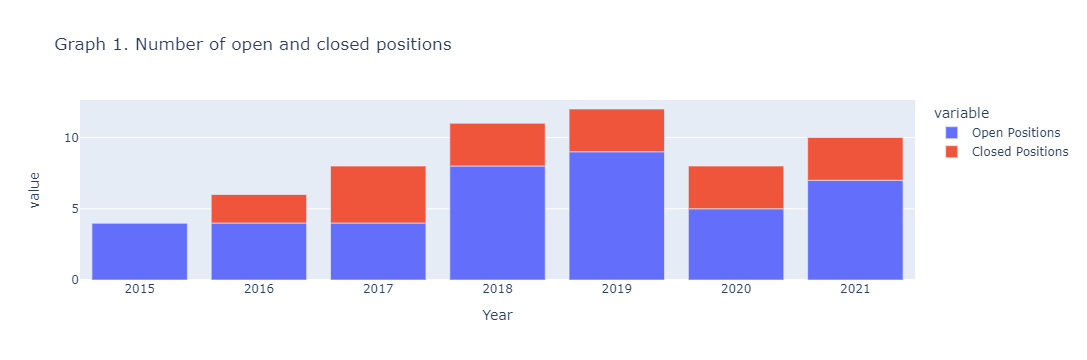

In [146]:
# get number of all complete iron condor transaction per year
all_trans = transaction.loc[transaction['OTM size'].isnull() != True].groupby(by = ['Year'])['OTM size'].count()/4
# get number of all offsetted iron condor transaction per year
closed_trans = transaction.loc[transaction['OTM size'].isnull() == True].groupby(by = ['Year'])['RIC'].count()/4

# create a dataframe of all and offsetted transaction counts
all_trans_df = pd.concat([all_trans, closed_trans], axis =1, keys = ['All positions',  'Closed Positions']).reset_index().fillna(0)
# add a column of open positions by subtracting closed positions from all positions
all_trans_df['Open Positions'] = all_trans_df['All positions'] - all_trans_df['Closed Positions']

# plot the results
fig = px.bar(all_trans_df, x = "Year", y = ["Open Positions", "Closed Positions"], title ='Graph 1. Number of open and closed positions')
fig.show()

As can be observed from the graph above, there have been missing transactions for several months throughout the years. This is because of the lack of liquidity in higher OTMs. For example, if we look at the short iron condor example with 5%/10% legs, we will observe many more complete transactions (you can try this by reading the excel file "short_IC5_10ndx1521.xlsx". Additionally, we can notice from the graph that three transactions are offsite during the observation period on average.

After we have the complete short iron condor transactions, we visualize the outcome through multiple graphs. First, we look at the total and cumulative sum of profits during the observation period.

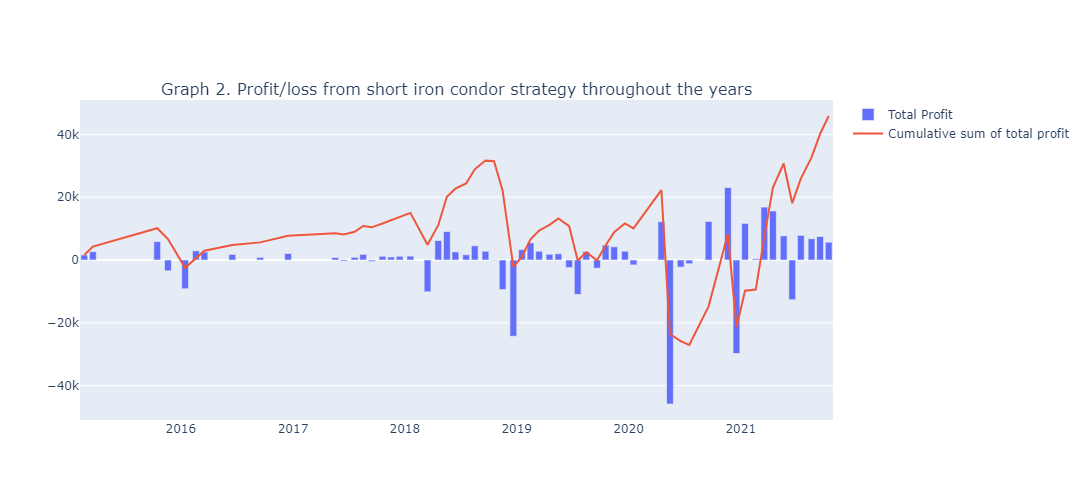

In [156]:
# get total profit/loss grouped by expiration date
df1 = transaction.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()

# create subplots and show total and cumulative sum of of total profit over the years
fig = make_subplots(subplot_titles = ['Graph 2. Profit/loss from short iron condor strategy throughout the years'])
fig.add_trace(go.Bar(x=df1['Exp_date'], y=df1['Total Profit/Loss'], name = 'Total Profit'))
fig.add_trace(go.Line(x=df1['Exp_date'], y=df1['Total Profit/Loss'].cumsum(), name = 'Cumulative sum of total profit'))

fig.update_layout(height=500, width=1100)
fig.show()

The graph above illustrates that the short iron condor strategy on NDX with 10%/20% OTM legs was primarily positive in terms of the cumulative sum of profits. There were three big plunges in the cumulative sum of the profits. First, was caused by the stock market tank in December 2018 caused by the [interest rate hikes](https://www.cnbc.com/2019/01/09/markets-december-tumble-may-have-hinted-at-profit-revisions-to-come.html ) by Federal Reserve System, which resulted in increased volatility. Volatility spikes caused the following two profit drops in May 2020 and December 2020 because of the impact of COVID on stock markets. After the two latter crashes, the cumulative sum of profits became negative, which regained during the following periods when markets became more stable.

Further, we look at the total profits and the ones attributed to Contract price and Exercise outcome components annually.

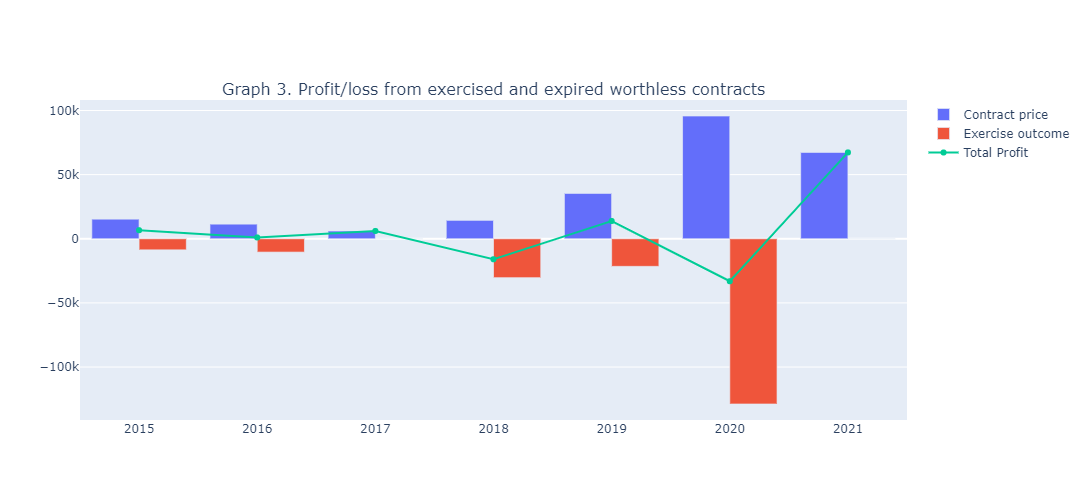

In [148]:
# create a dataframe of profits from Contract price and Exercise outcome grouped by year
newdf = transaction.groupby(by = ['Year'])['Contract price','Exercise outcome', 'Total Profit/Loss' ].sum().reset_index()

# plot the dataframe
fig = make_subplots(subplot_titles = ['Graph 3. Profit/loss from exercised and expired worthless contracts'])
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Contract price'], name = 'Contract price'))
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Exercise outcome'], name = 'Exercise outcome'))
fig.add_trace(go.Line(x=newdf['Year'], y=newdf['Total Profit/Loss'], name = 'Total Profit'))

fig.update_layout(height=500, width=1100)
fig.show()

Here we experience a similar picture to the one from the graph above regarding the total profits. Particularly, we observe negative total profits for 2018 and 2020, and the profit is reaching its maximum in 2021. As expected, we can see that the profits are generated from contract price differences, whereas Exercised options resulted in losses. This is because one benefits from the short iron condor strategy when the price is between strike prices of short positions and options become worthless at expiration.

Next, we also look at the number of exercised and expired worthless contracts along with total profits.

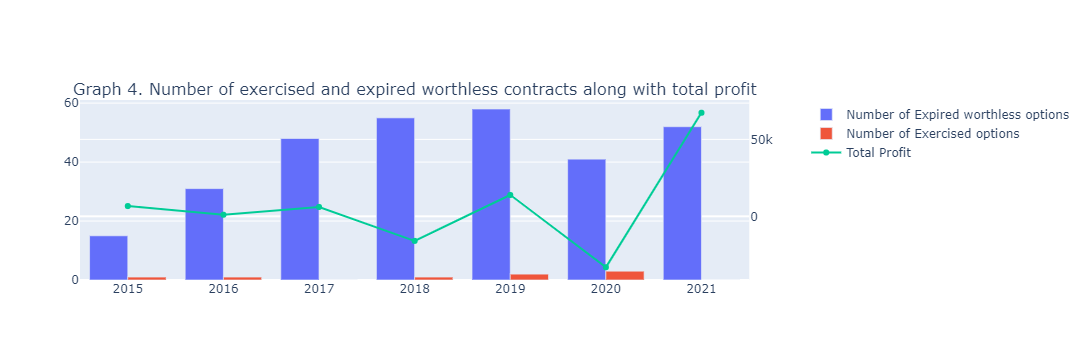

In [149]:
df2 = transaction.groupby(by = ['Year', 'Outcome', 'Trans_Date', 'Exp_date', 'Option type', 'Position'])['Total Profit/Loss'].sum().reset_index()

# create separate dataframes for number of erxercised, expired options and profits grouped by year
exer = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Exercised option'].count()).reset_index()
exp = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Expired worthless'].count()).reset_index()
prof = df2.groupby(by = ['Year'])['Total Profit/Loss'].sum().reset_index()

# plot the results using barplots and lineplot
fig = make_subplots(specs=[[{"secondary_y": True}]], subplot_titles = ['Graph 4. Number of exercised and expired worthless contracts along with total profit'])
fig.add_trace(go.Bar(x = exp['Year'], y = exp['Outcome'], name = "Number of Expired worthless options"), secondary_y = False)
fig.add_trace(go.Bar(x = exer['Year'], y = exer['Outcome'], name = "Number of Exercised options"), secondary_y = False)
fig.add_trace(go.Line(x = prof['Year'], y = prof['Total Profit/Loss'], name = "Total Profit"), secondary_y = True)
fig.show()

We can see from the graph above that most of the options expired worthless. Only 1-3 options contracts were exercised, resulting in losses presented in the previous graph. Particularly, three exercised options from 2020 resulted in losses of $128,818.

Further, we deep dive and look at the individual components of iron condor strategy, such as profits from call options versus put options, short positions versus long positions, and profits from 4 different legs of the strategy. First, we create the dataframes as shown in the cell below and then plot the results.

In [150]:
# create a dataframe for profits from exercised versus expired options 
df3 = df2.groupby(by = ['Year', 'Outcome'])['Total Profit/Loss'].sum().reset_index()
exer = df3.loc[df3["Outcome"] == "Exercised option"]
exp = df3.loc[df3["Outcome"] == "Expired worthless"]

# create a dataframe for profits from call versus put options 
df4 = df2.groupby(by = ['Year', 'Option type'])['Total Profit/Loss'].sum().reset_index()
call = df4.loc[df4["Option type"] == "call"]
put = df4.loc[df4["Option type"] == "put"]

# create a dataframe for profits from short versus long positions 
df5 = df2.groupby(by = ['Year', 'Position'])['Total Profit/Loss'].sum().reset_index()
short = df5.loc[df5["Position"] == "short"]
long = df5.loc[df5["Position"] == "long"]

# create a dataframe for profits from different legs of short iron condor strategy
df6 = df2.groupby(by = ['Year', 'Position', 'Option type'])['Total Profit/Loss'].sum().reset_index()
df6['Option'] = df6['Position'] + df6['Option type']
Long_call = df6.loc[df6["Option"] == "longcall"]
long_put = df6.loc[df6["Option"] == "longput"]
short_call = df6.loc[df6["Option"] == "shortcall"]
short_put = df6.loc[df6["Option"] == "shortput"]

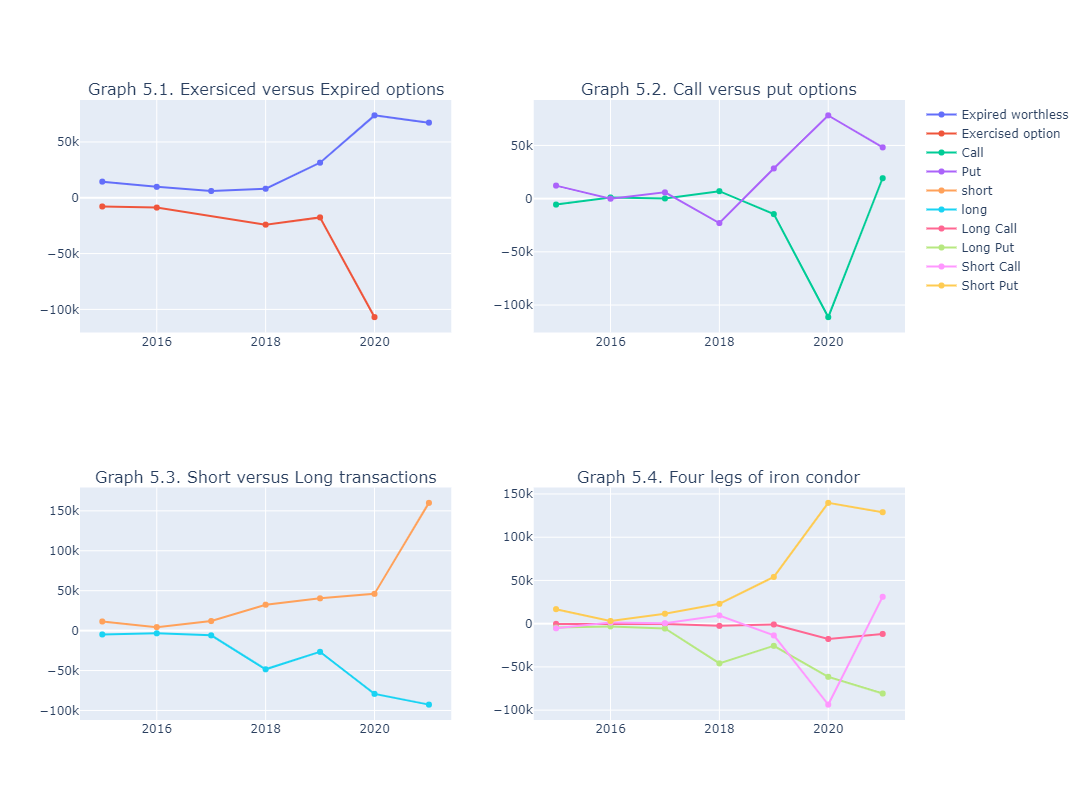

In [151]:
fig = make_subplots(
    rows=2, cols=2, subplot_titles=[
        'Graph 5.1. Exersiced versus Expired options',
        'Graph 5.2. Call versus put options',
        'Graph 5.3. Short versus Long transactions',
        'Graph 5.4. Four legs of iron condor'])

fig.add_trace(go.Line(x=exp["Year"], y=exp["Total Profit/Loss"],
                      name='Expired worthless'), row=1, col=1)
fig.add_trace(go.Line(x=exer["Year"], y=exer["Total Profit/Loss"],
                      name='Exercised option'), row=1, col=1)

fig.add_trace(go.Line(x=call["Year"], y=call["Total Profit/Loss"],
                      name='Call'), row=1, col=2)
fig.add_trace(go.Line(x=put["Year"], y=put["Total Profit/Loss"],
                      name='Put'), row=1,col=2)

fig.add_trace(go.Line(x=short["Year"], y=short["Total Profit/Loss"],
                      name='short'), row=2, col=1)
fig.add_trace(go.Line(x=long["Year"], y=long["Total Profit/Loss"],
                      name='long'), row=2,col=1)

fig.add_trace(go.Line(x=Long_call["Year"], y=Long_call["Total Profit/Loss"],
                      name='Long Call'), row=2, col=2)
fig.add_trace(go.Line(x=long_put["Year"], y=long_put["Total Profit/Loss"],
                      name='Long Put'),  row=2,col=2)
fig.add_trace(go.Line(x=short_call["Year"], y=short_call["Total Profit/Loss"],
                      name='Short Call'), row=2, col=2)
fig.add_trace(go.Line(x=short_put["Year"], y=short_put["Total Profit/Loss"],
                      name='Short Put'),  row=2,col=2)

fig.update_layout(height=800, width=1100)
fig.for_each_yaxis(lambda axis: axis.title.update(
    font=dict(color='blue', size=5)))

fig.show()


Looking at the graphs one by one, we can observe that, as expected, expired options resulted in most of the profits and exercised one's losses. Moving to the profits from call versus put options, we can claim that put options mainly were profitable, and call options resulted in losses with an exception from 2018. Additionally, short transactions when we received option premium resulted in profits and long positions to lose, which is expected since most contracts expired worthless. Finally, short put options contributed most to the strategy's returns, whereas long put and short call legs mostly resulted in losses. This is because the market mainly moved upwards during the observation period.

Finally, we plot the returns from the strategy per month to see whether there is a tendency for the short iron condor strategy to be profitable or losable during certain months regularly.

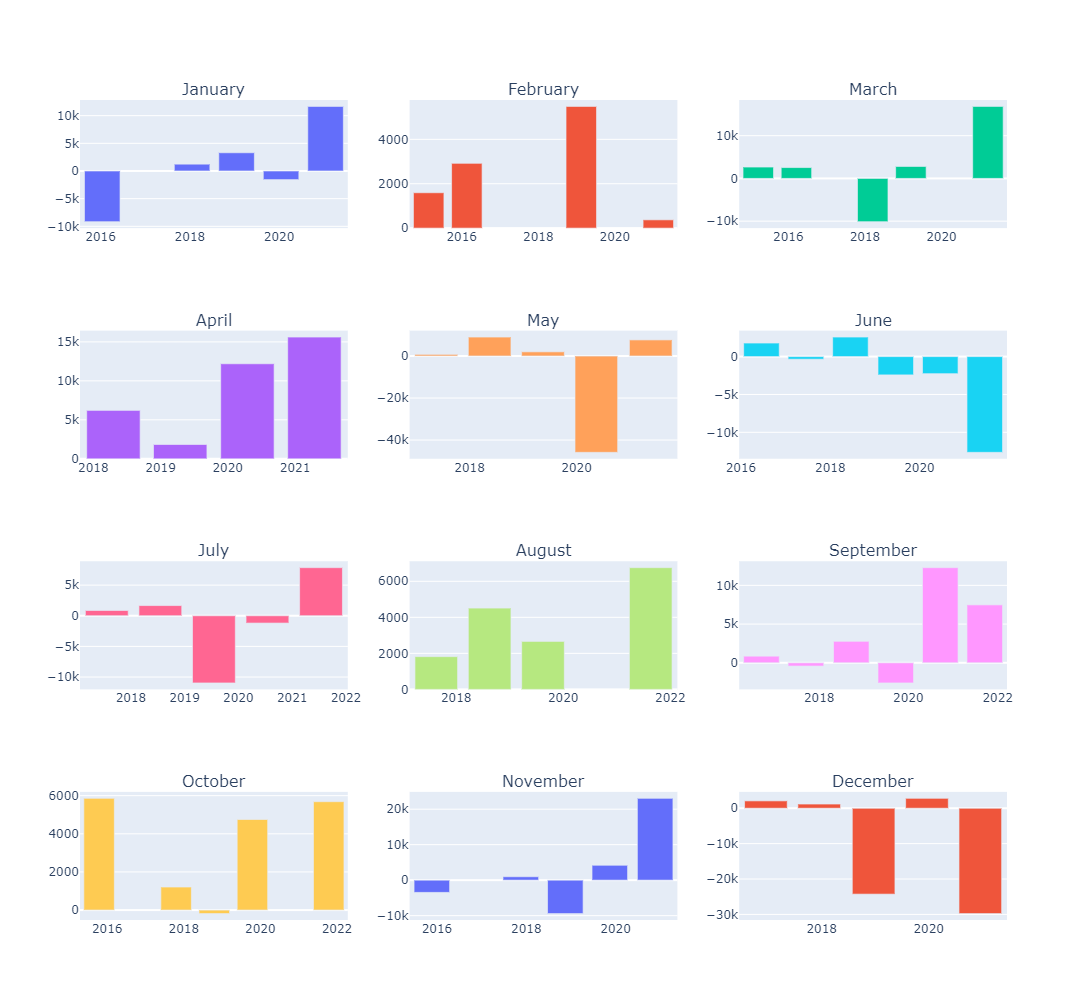

In [152]:
fig = make_subplots(rows=4, cols=3,
        subplot_titles = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] )

n = 0
for i in range(1,5):
    for j in range(1, 4):
        n += 1
        x = df1['Exp_date'].loc[(df1['Exp_date'].dt.month==n)]
        y = df1['Total Profit/Loss'].loc[(df1['Exp_date'].dt.month==n)]
        fig.add_trace(
            go.Bar(x=x , y=y,showlegend=False),
            row=i, col=j
        )
fig.update_layout(height=1000, width=1100)

fig.show()

## Summary

This article walked through the backtesting of a short iron condor strategy with 10%/20% legs for option contracts written on NDX as an underlying. The estimates are done from 2015 to 2021 October included. The most important and, at the same time, challenging part of the backtesting was the reconstruction of expired option RICs as those are not easily accessible through a single API call. We illustrated the construction process and built functions to reconstruct and validate RICs for OPRA exchange-traded indices and equities monthly options. It is worth mentioning that the reconstruction part can be used as a standalone product for other use cases different than strategy backtesting.

Further, moving to the actual backtesting, we built functions to create transactions for short iron condor strategy legs and offset those with opposite transactions in case of a market trigger. As a market trigger, we used the three-day MA change. Finally, we calculated the strategy outcome and visualized the results with different graphs. Although all the processes above are showcased for NDX, we run the backtesting for SPX, IBM, TWTR and AAPL as well. The datasets of options transactions during 2015-2021 for those assets are included in the GitHub folder.

It is also worth mentioning the limitations of the current backtesting tool. First of all, the expired option RIC reconstruction is not easily scalable. One may not learn and incorporate exchange and Refinitiv rules for other types of assets, such as FX, and other expiration periods, such as weekly. Next, the solution involves many API requests and depending on the option and number of years to request, one may hit the daily limit. Thus, it is advised to request data for relatively short periods and export the retrieved output to excel. Then the outputs can be merged, and visualizations run for the entire period of observation. Finally, at larger OTMs and for certain assets, the market may not be very liquid, and one may end up having no options contracts to trade for some months.